<a href="https://colab.research.google.com/github/murakamixi/suumo_cnn_tensorflow/blob/train_cmm/fine_turning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [7]:
classes = ['bathroom', 'genkan', 'kitchen', 'mitorizu', 'senmenjo', 'wc',]
nb_classes = len(classes)

img_width, img_height = 64, 64

#traning and validation data dir
train_data_dir = './data/train'
validation_data_dir = './data/validation'

nb_train_samples = 81
nb_validation_samples = 81

batch_size = 16
nb_epoch = 10

In [8]:
# トレーンング用、バリデーション用データを生成するジェネレータ作成
train_datagen = ImageDataGenerator(
  rescale=1.0 / 255,
  zoom_range=0.2,
  horizontal_flip=True)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
  train_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
  validation_data_dir,
  target_size=(img_width, img_height),
  color_mode='rgb',
  classes=classes,
  class_mode='categorical',
  batch_size=batch_size,
  shuffle=True)

Found 39 images belonging to 6 classes.
Found 39 images belonging to 6 classes.


In [9]:
from keras.models import Model
from keras import optimizers
from keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16
import os


# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# FC層の作成
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_classes, activation='softmax'))

# VGG16とFC層を結合してモデルを作成
vgg_model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# 最後のconv層の直前までの層をfreeze
for layer in vgg_model.layers[:15]:
    layer.trainable = False

# 多クラス分類を指定
vgg_model.compile(loss='categorical_crossentropy',
            optimizer=optimizers.SGD(lr=1e-3, momentum=0.9),
            metrics=['accuracy'])

In [10]:
from keras.models import Model
from keras import optimizers
from keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16
# VGG16のロード。FC層は不要なので include_top=False
input_tensor = Input(shape=(64, 64, 3))

vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [11]:
result_dir = './results'
# Fine-tuning
history = vgg_model.fit_generator(
    generator=train_generator,
    # samples_per_epoch=nb_train_samples,
    epochs=nb_epoch,
    validation_data=validation_generator,
    # nb_val_samples=nb_validation_samples
    )

# 重みを保存
vgg_model.save_weights(os.path.join(result_dir, 'finetuning.h5'))

/Users/m.kazu/opt/anaconda3/envs/suumo_tensor_py39/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-06-10 13:36:39.862832: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
3/3 [==============================] - 3s 1s/step - loss: 1.8124 - accuracy: 0.4445 - val_loss: 0.8920 - val_accuracy: 0.5385
Epoch 2/10
3/3 [==============================] - 2s 640ms/step - loss: 0.8289 - accuracy: 0.6474 - val_loss: 0.4950 - val_accuracy: 0.7692
Epoch 3/10
3/3 [==============================] - 2s 544ms/step - loss: 0.6808 - accuracy: 0.7650 - val_loss: 0.2908 - val_accuracy: 0.9231
Epoch 4/10
3/3 [==============================] - 2s 690ms/step - loss: 0.4774 - accuracy: 0.7480 - val_loss: 0.2270 - val_accuracy: 0.9744
Epoch 5/10
3/3 [==============================] - 2s 681ms/step - loss: 0.3459 - accuracy: 0.8336 - val_loss: 0.1997 - val_accuracy: 0.9487
Epoch 6/10
3/3 [==============================] - 2s 538ms/step - loss: 0.3219 - accuracy: 0.8243 - val_loss: 0.1280 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 2s 595ms/step - loss: 0.1488 - accuracy: 0.9635 - val_loss: 0.1091 - val_accuracy: 0.9487
Epoch 8/10
3/3 [=======

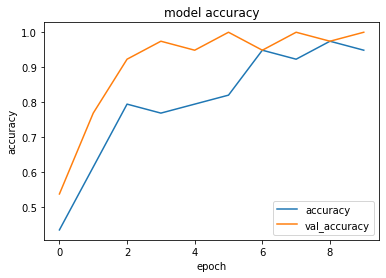

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'], loc='lower right')
plt.show()